<a href="https://colab.research.google.com/github/estbasili/BD-ML/blob/main/clustering_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
archivo = '/content/drive/MyDrive/UPSO/ML/Crimenes.csv'

#carga el archivo CSV
df_original = pd.read_csv(archivo)



# Analizando los datos del dataset

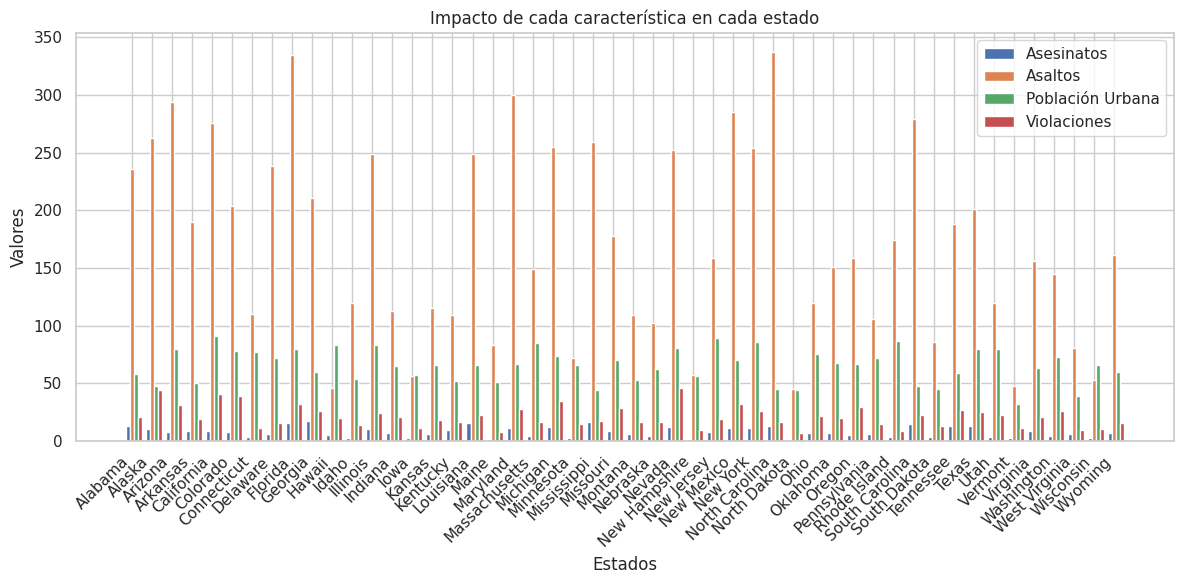

In [41]:
# Datos
estados = df_original['Estado']
asesinatos = df_original['Asesinatos']
asaltos = df_original['Asaltos']
poblacion_urbana = df_original['Poblacion Urbana']
violaciones = df_original['Violaciones']

# Creo un índice para los estados
x = np.arange(len(estados))

# Creo gráficos de barras para cada característica
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, asesinatos, width, label='Asesinatos')
rects2 = ax.bar(x, asaltos, width, label='Asaltos')
rects3 = ax.bar(x + width, poblacion_urbana, width, label='Población Urbana')
rects4 = ax.bar(x + 2*width, violaciones, width, label='Violaciones')

# Añado etiquetas, título y leyenda
ax.set_xlabel('Estados')
ax.set_ylabel('Valores')
ax.set_title('Impacto de cada característica en cada estado')
ax.set_xticks(x)
ax.set_xticklabels(estados, rotation=45, ha='right')
ax.legend()

#Gráfico
plt.tight_layout()
plt.show()


## Calculando la incidencia que tienen cada caracteristica respecto a cada estado

In [42]:
# Funcion que calcula la incidencia de la caracteristica con respecto a la población urbana (por cada 100,000 habitantes)
def graficarIncidencia (caracteristica):
  df= df_original.copy()

  df[f'Incidencia_{caracteristica}'] = (df[caracteristica] / df['Poblacion Urbana']) * 100000
  # Calculo la incidencia total de la caracteristica respecto a la población urbana total
  total_caracteristica = df[caracteristica].sum()
  total_poblacion_urbana = df['Poblacion Urbana'].sum()
  incidencia_total = (total_caracteristica / total_poblacion_urbana) * 100000

  # Grafico la incidencia de la caracteristica por estado
  plt.figure(figsize=(12, 6))
  plt.bar(df['Estado'], df[f'Incidencia_{caracteristica}'], color='blue', label='Incidencia por Estado')
  plt.axhline(y=incidencia_total, color='red', linestyle='--', label= f'Incidencia total de {caracteristica} en el total de Estado')

  plt.title(f'Incidencia de {caracteristica} por cada 100,000 habitantes por Estado')
  plt.xlabel('Estado')
  plt.ylabel(f'Incidencia de {caracteristica} por 100,000 habitantes')
  plt.xticks(rotation=90)
  plt.legend()
  plt.grid(axis='y')

  plt.show()


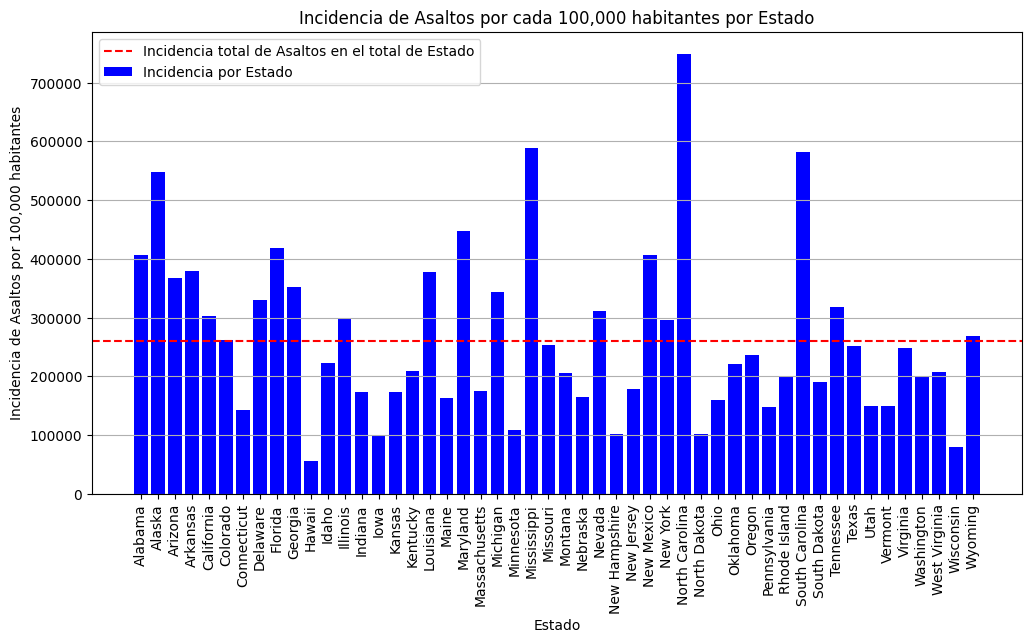

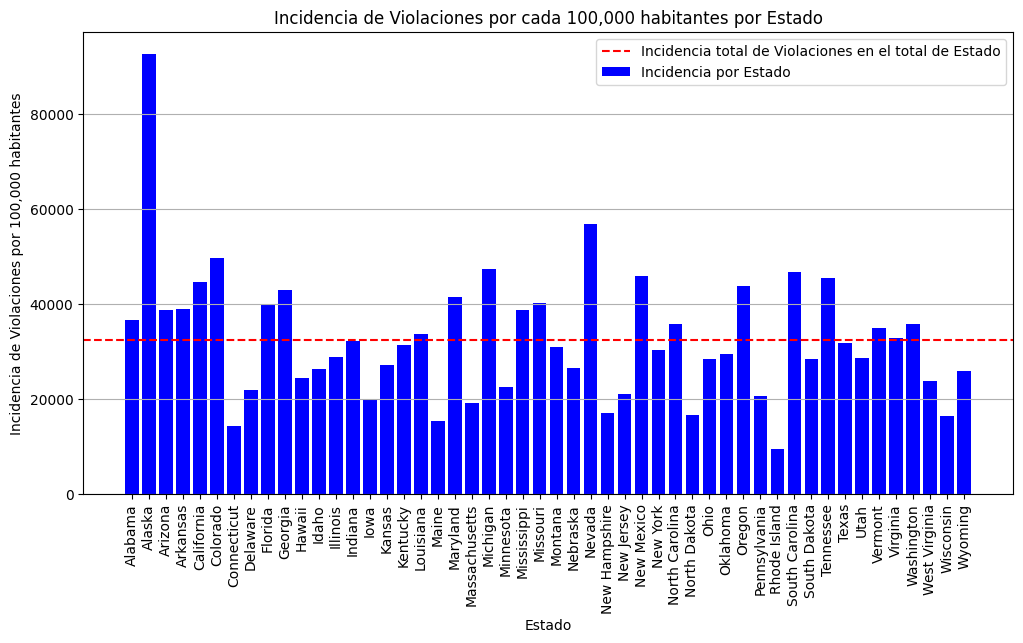

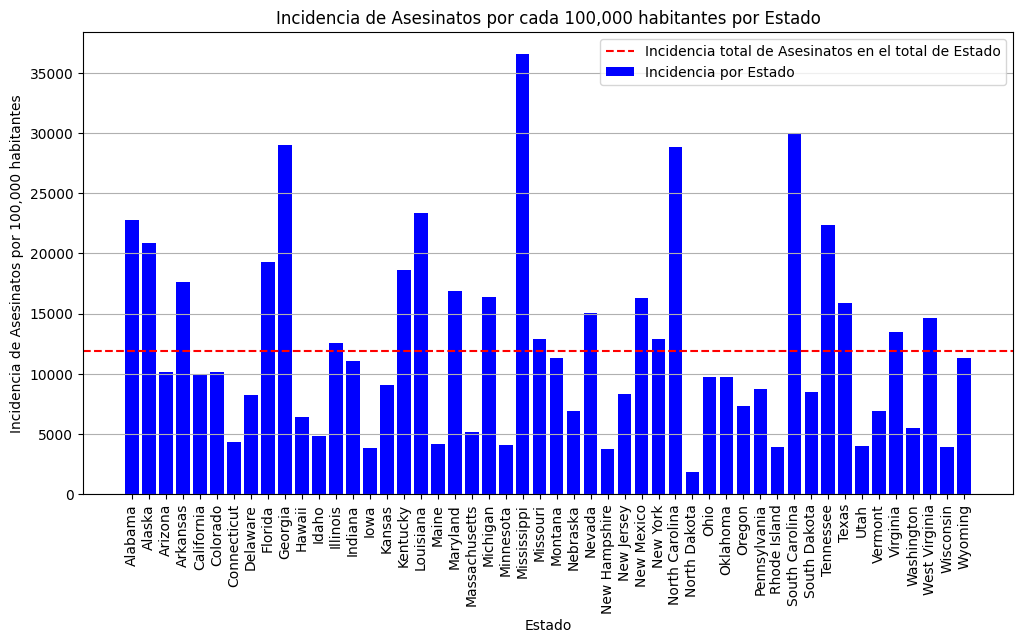

In [ ]:
#llamo a la funcion graficarIncidencia con las caracteristicas de: Asesinatos, Asaltos, Violaciones
graficarIncidencia('Asaltos')
graficarIncidencia('Violaciones')
graficarIncidencia('Asesinatos')

Como se puede apreciar, de las caracteristicas Asesinatos, Violaciones y Asaltos. Las mas representativas son Asaltos y Violaciones. Ya que los valores estan mas proximos a la media total de incidencia de dicha caracteristica en la poblacion total (linea puntiada roja).
Pero si tomamos para nuestro estudio, que las zonas peligrosas son aquellas con mas casos de violaciones y asesinatos. Se podran elegir estas dos ultimas caracteristicas. Ya que, no todo asalto termina en asesinato o violacion.

# Clustrizacion en tres zonas: zona de alta peligrosidad, zona de media peligrosidad  y zona de baja peligrosidad. De acuerdo al modelo de clusterizacion KMeans y utilizando las caracteristicas: 'Violaciones' y 'Asesinatos'

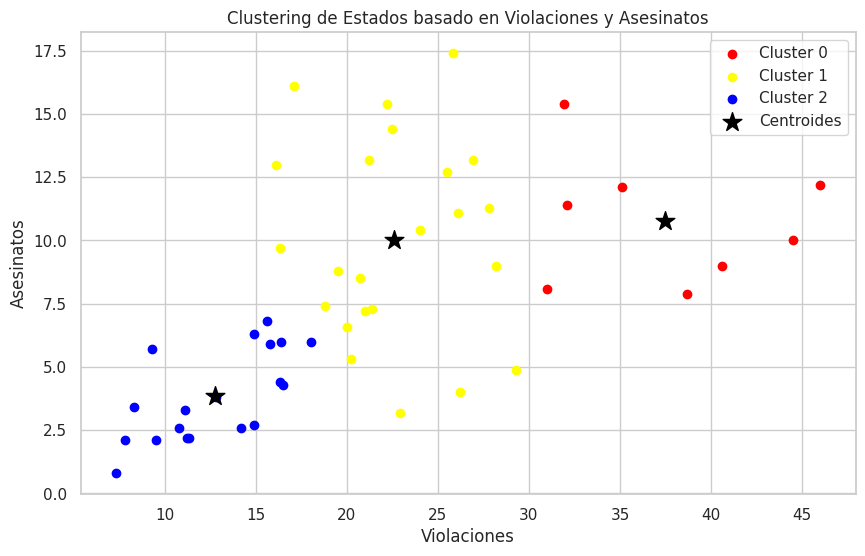

In [43]:
# Clustering Kmeans
# Selecciono las características para el clustering
X = df_original[['Violaciones', 'Asesinatos']]

# Inicializo el modelo K-means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Ajusto
kmeans.fit(X)

# Agrego las etiquetas de cluster al DataFrame
df_original['Cluster'] = kmeans.labels_

# Grafico los resultados del clustering
plt.figure(figsize=(10, 6))

# asigno un color a cada cluster
colors = ['red', 'yellow', 'blue']

# Grafico puntos por cluster
for i in range(3):
    cluster_data = df_original[df_original['Cluster'] == i]
    plt.scatter(cluster_data['Violaciones'], cluster_data['Asesinatos'], c=colors[i], label=f'Cluster {i}')

# Grafico los centroides de cada cluster
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=200, c='black', label='Centroides')

plt.title('Clustering de Estados basado en Violaciones y Asesinatos')
plt.xlabel('Violaciones')
plt.ylabel('Asesinatos')
plt.legend()
plt.grid(True)
plt.show()




Analizando cada cluster

In [44]:
# Calculo las estadísticas resumidas por cluster
cluster_stats = df_original.groupby('Cluster').agg({'Violaciones': ['mean', 'std'], 'Asesinatos': ['mean', 'std']}).reset_index()

# Imprimo las estadísticas resumidas
print()
print("Estadísticas Resumidas por Cluster:\n")

print(cluster_stats)


Estadísticas Resumidas por Cluster:

  Cluster Violaciones           Asesinatos          
                 mean       std       mean       std
0       0   37.487500  5.865501  10.762500  2.528092
1       1   22.595652  3.850558  10.004348  3.982288
2       2   12.736842  3.365051   3.852632  1.793621


De la tabla anterior, podemos apreciar:

> cluster 0 (roja)   => zona de peligrosidad alta
>
> cluster 1 (amarillo)  => zona de peligrosidad media
>
> cluster 2 (azul)   => zona de peigrosidad baja

Conclución: Tomando las caracteristicas de Violaciones y Asesinatos. El modelo Kmeas agrupo los estados en las distintas zonas, de la siguiente manera:

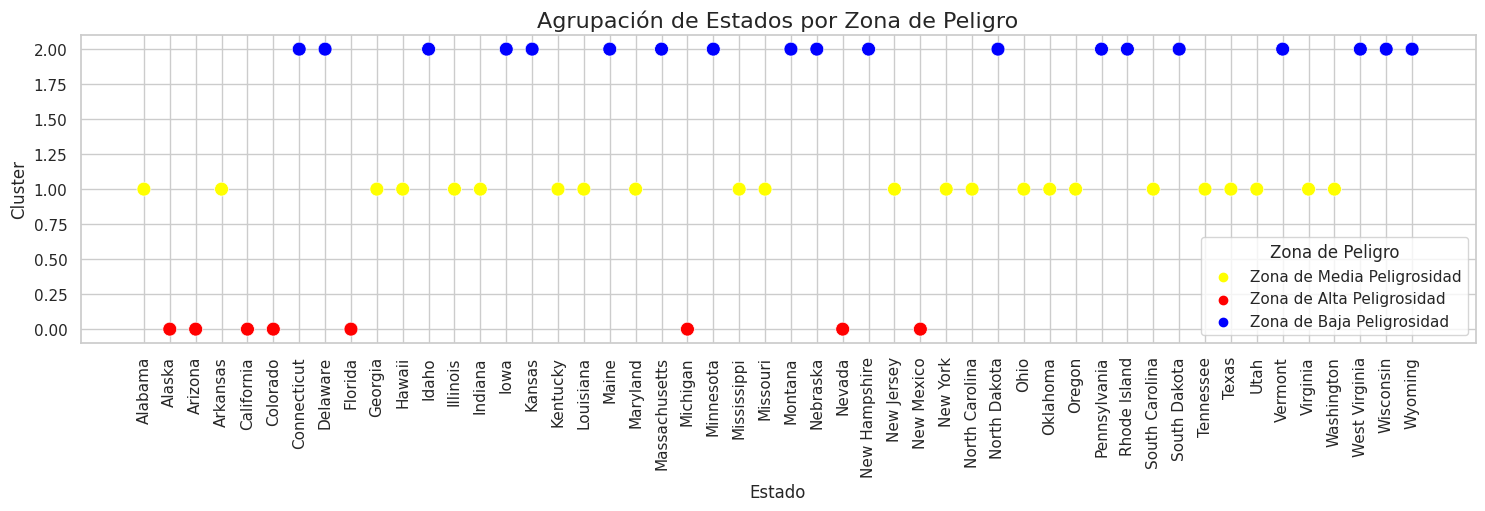

In [45]:
df = df_original[['Estado', 'Cluster']].copy()
# Mapeo etiquetas de clusters a zonas de peligro
df['Zona de Peligro'] = df['Cluster'].map({0: 'Zona de Alta Peligrosidad', 1: 'Zona de Media Peligrosidad', 2: 'Zona de Baja Peligrosidad'})

# Configuro el estilo de seaborn
sns.set(style="whitegrid")

# Creo un mapa de colores personalizado para las zonas de peligro
colores = {'Zona de Alta Peligrosidad': 'red', 'Zona de Media Peligrosidad': 'yellow', 'Zona de Baja Peligrosidad': 'blue'}

# Creo el gráfico de dispersión
plt.figure(figsize=(18,4))
sns.scatterplot(x='Estado', y='Cluster', data=df, hue='Zona de Peligro', palette=colores, s=100, edgecolor='w', linewidth=0.5)
plt.title('Agrupación de Estados por Zona de Peligro', fontsize=16)
plt.xticks(rotation=90)
plt.legend(title='Zona de Peligro')

#Representación en el mapa de Estados Unidos

#para realizar el grafico necesito las abrevituras de los estados por lo cual asigno a un data frame las abreviasiones para luego colocarlo en el dataframe de la prediccion
code=pd.DataFrame({'code':['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME',
                            'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA', 'RI',
                            'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']})

#realizo un nuevo dataframe
Peligrosidad_zonas_df=pd.DataFrame({'Code':code['code'],'Estado':df['Estado'],'Cluster':df['Cluster'],'Zona de Peligro':df['Zona de Peligro']})

#realizo el grafico
fig = px.choropleth(Peligrosidad_zonas_df, locations='Code', locationmode="USA-states", scope="usa",
                    color='Zona de Peligro',title='Represetación en el mapa',hover_name='Estado',color_discrete_map=colores)

fig.show()


**Nota: El mapa de Estados Unidos en github no se esta representando, porque el es interactivo.**